# Interfaces de PyTorch
Para facilitar la definición, entrenamiento e inferencia de redes neuronales profundas con diversas arquitecturas y tipos de capas, PyTorch provee clases y funciones a distintos niveles de abstracción. En esta libreta revisaremos las interfaces principales.

![](https://manalelaidouni.github.io/assets/img/pexels/Pytorch-package-hierarchy.jpg)

Fuente: [https://manalelaidouni.github.io/Pytorch%20guide%20101.html](https://manalelaidouni.github.io/Pytorch%20guide%20101.html)

In [ ]:
from math import floor

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import torch as th
from torch import nn
from torch.optim import SGD

## Conjunto de datos
Usaremos el conjunto de datos de regresión Diabetes Dataset que se puede obtener con scikit-learn.

In [ ]:
db = load_diabetes()

Dividimos este conjunto en subconjuntos de entrenamiento y prueba usando la función `train_test_split` de scikit-learn.

In [ ]:
X_ent, X_prueba, y_ent, y_prueba = train_test_split(db['data'],
                                                    db['target'],
                                                    test_size = 0.3,
                                                    shuffle=True)

Convertimos los subconjuntos de arreglos de NumPy a instancias de `Tensor` de PyTorch y los cargamos al GPU (si está disponible). Para evitar errores de tipos de datos distintos de los operandos, es importante asegurarse de que coincidan. En esta libreta vamos a trabajar con enteros de 32 bits, por lo que lo especificamos en la función `tensor`.

In [ ]:
disp = 'cuda:0' if th.cuda.is_available() else 'cpu'

X_ent = th.tensor(X_ent, dtype = th.float32, device = disp)
X_prueba = th.tensor(X_prueba, dtype = th.float32, device = disp)

y_ent = th.tensor(y_ent,  dtype = th.float32, device = disp)
y_prueba = th.tensor(y_prueba, dtype = th.float32,  device = disp)

print(f'Formas de X_ent = {X_ent.shape}, X_prueba = {X_prueba.shape}')
print(f'Formas de y_ent = {y_ent.shape}, y_prueba = {y_prueba.shape}')

Formas de X_ent = torch.Size([309, 10]), X_prueba = torch.Size([133, 10])
Formas de y_ent = torch.Size([309]), y_prueba = torch.Size([133])


También es importante asegurarse de que las formas de los tensores de las predicciones (`y_hat`) y de los salidas reales (`y`) sean iguales. Aquí vamos a presuponer que son vectores columnas de $n \times 1$, por lo que cambiamos de forma.

In [ ]:
y_ent = y_ent.reshape((y_ent.shape[0], 1))
y_prueba = y_prueba.reshape((y_prueba.shape[0], 1))
print(f'Formas de y_ent = {y_ent.shape}, y_prueba = {y_prueba.shape}')

Formas de y_ent = torch.Size([309, 1]), y_prueba = torch.Size([133, 1])


## Clase `Module` de `nn`
Muchas de las clases y funciones para definir, entrenar y evaluar redes neuronales están contenidas el módulo `nn` de PyTorch. En particular contamos con la clase [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), una plantilla base para definir los distintos componentes de una arquitectura de red (ver [https://pytorch.org/docs/stable/notes/modules.htm](https://pytorch.org/docs/stable/notes/modules.html)). De hecho, hay varias subclases predefinidas de `Module` asociadas a diversos tipos de capas. Por ej., la subclase [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) representa una capa densa o completamente conectada. Esta subclase tiene como argumentos no opcionales la dimension de los vectores de entrada y el número de neuronas (dimensión de los vectores de salida). Una instancia de `Linear` procesa una matriz de tamaño $n \times \text{in_features}$, la cual multiplica por la transpuesta de una matriz de pesos de $\text{out_features} \times \text{in_features}$ y le suma un vector de sesgos de tamaño $\text{out_features}$

In [ ]:
clin = nn.Linear(in_features = X_ent.shape[-1], # dimensión de entradas
                 out_features = 1, # número de neuronas (dimensión de salidas)
                 bias = True) # si usar sesgo o no

Podemos especificar que se cree directamente una instancia de cualquier subclase de `Module` en el CPU o en el GPU pasando el argumento `device=nombre_del_dispositivo` al constructor. También podemos mover una instancia ya creada de un dispositivo a otro con el método `to(nombre_del_dispositivo)`. Movemos la instancia de `Linear` al GPU.

In [ ]:
clin.to(disp)

Linear(in_features=10, out_features=1, bias=True)

Obtenemos la salida de la capa para el conjunto de datos de entrenamiento mediante el operador de paréntesis.

In [ ]:
clin(X_ent).shape

torch.Size([309, 1])

Para definir una nueva capa, un nuevo bloque o una red debemos crear una subclase de `Module` y especificar como mínimo los métodos:
- `__init__`, que es el constructor de la subclase y en el cual se tiene que llamar al constructor de la clase base `Module` mediante la función `super` de Python.
- `forward`, que define lo que se ejecuta al llamar al operador paréntesis en una instancia de dicha clase.

Por ej. para crear nuestra propia capa densa en el método `__init__` (constructor) recibiríamos la dimensión de las entradas y el número de neuronas (dimensión de las salidas) e instanciaríamos la matriz de pesos $\mathbf{W} \in \mathbb{R}^{d \times k}$ y el vector de sesgos $\mathbf{b} \in \mathbb{R}^k$. En el método `forward` se esperaría una matriz de $\mathbf{X} \in \mathbb{R}^{n \times d}$ como entrada y se realizaría la operación $\mathbf{X} \cdot \mathbf{W}^\top + \mathbf{b}$.

In [ ]:
class MiLinear(nn.Module):
  # En el constructor recibimos la dimensión de las entradas y la de las salidas
  # e instanciamos la matriz de pesos W y el vector de sesgos b inicializándolos
  # con números aleatorios y ceros, respectivamente.
  def __init__(self, d_ent, d_sal):
    super(MiLinear, self).__init__()
    self.d_ent = d_ent
    self.d_sal = d_sal
    self.W = nn.Parameter(th.normal(size = (d_sal, d_ent), mean = 0, std = 0.1))
    self.b = nn.Parameter(th.zeros(d_sal, dtype = th.float32))

  # En este método se define el comportamiento del operador paréntesis. Al ser
  # una capa densa, se espera recibir una matriz x de n x d_ent y se realizaría
  # la operación de multiplicación de esta con la transpuesta de la matriz de
  # pesos de d_sal x d_ent y se sumaría el vector de sesgos de d_sal elementos
  def forward(self, x):
    return x @ self.W.T + self.b

  # Podemos sobreescribir el método reset_parameters de Module con el que se
  # inicializan nuevamente los valores de los pesos y sesgos.
  def reset_parameters(self):
    self.W = nn.Parameter(th.normal(size = (d_ent, d_sal), mean = 0, std = 0.1))
    self.b = nn.Parameter(th.zeros(d_sal, dtype = th.float32))

  # especificamos la cadena que se despliega cuando
  # se imprime una instancia
  def extra_repr(self):
    return f'd_ent={self.d_ent}, d_sal={self.d_sal}'

Instanciamos la subclase de nuestra capa densa, la movemos a la GPU y pasamos el conjunto de entrenamiento.

In [ ]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)

print(f'Instancia de {milin} con forma = {milin(X_ent).shape}')

Instancia de MiLinear(d_ent=10, d_sal=1) con forma = torch.Size([309, 1])


Para facilitar el entrenamiento de los modelos vamos a definir una función para un paso de entrenamiento, a la cual llamaremos `paso_ent`. Esta función recibe como argumento:
- El modelo como una instancia de `Module` (`modelo`).
- Una función o funtor que calcula la pérdida (`fp`).
- Una instancia de Tensor con las entradas (`X`).
- Una instancia de Tensor con las salidas (`y`).
- El valor de la tasa de aprendizaje (`tasa`).

La función obtiene las predicciones del modelo para las entradas, calcula la pérdida, obtiene los gradientes y actualiza todos los parámetros del modelo mediante descenso por gradiente.

In [ ]:
def paso_ent(modelo, fp, X, y, tasa):
  y_hat = modelo(X) # propagamos las entradas para  obtener las predicciones
  perdida = fp(y_hat, y) # calculamos la función de pérdida
  perdida.backward() # obtenemos los gradientes

  with th.no_grad():
    # actualizamos todos los parámetros del modelo usando descenso por gradiente
    for p in modelo.parameters():
      p.subtract_(tasa * p.grad)
      p.grad.zero_() # se tienen que poner los gradientes a cero una vez que
                     # se actualizan los parámetros correspondientes

    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
  return perdida_paso

También definimos una función para el ciclo de entrenamiento principal, que llamaremos `entrena`. Esta función recibe los mismos argumentos que `paso_ent` más el tamaño del lote y el número de épocas de entrenamiento. Para cada una de las épocas, esta función genera una permutación aleatoria de todos los pares entrada-salida y va tomando un lote entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento.

In [ ]:
def entrena(modelo, fp, X, y, tasa = 1e-3, t_lote = 32, n_epocas = 100):
  n_lotes = floor(X.shape[0] / t_lote)# se calcula el número de lotes (si el
                                      # tamaño del último lote < t_lote se
                                      # ignora
  hist = [] # para guardar las pérdidas por época
  for e in range(n_epocas):
    perdida = 0
    perm = th.randperm(X.shape[0]) # se genera una permutación aleatoria
    Xperm = X[perm] # se reordenan las entradas y
    yperm = y[perm] # las entradas usando la permutación

    for lote in range(n_lotes): # se van tomando t_lote entradas y salidas
      Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
      ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
      perdida += paso_ent(modelo, fp, Xlote, ylote, tasa) # se realiza paso de
                                                          # entrenamiento
    hist.append(perdida)

  return hist

Como función de pérdida emplearemos el error cuadrático medio (ECM) definido como

$$
\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{n}\sum_{i=1}^n (\hat{y}^{(i)} - y^{(i)})^2
$$

PyTorch incluye varias funciones de pérdida predefinidas dentro del submódulo `functional` del módulo `nn`, además de clases que envuelven estas funciones, cuyas instancias se conocen como criterios. Por ej. la función `mean_squared_error` de `functional` define el ECM y la clase `MSELoss` de `nn` es su correspondiente criterio. la cual define la función de pérdida de error cuadrático medio definida como criterios. Movemos la instancia de nuestra capa densa al GPU, creamos el criterio de ECM instanciando la clase `MSELoss`, entrenamos nuestro modelo de regresión lineal y graficamos la pérdida.

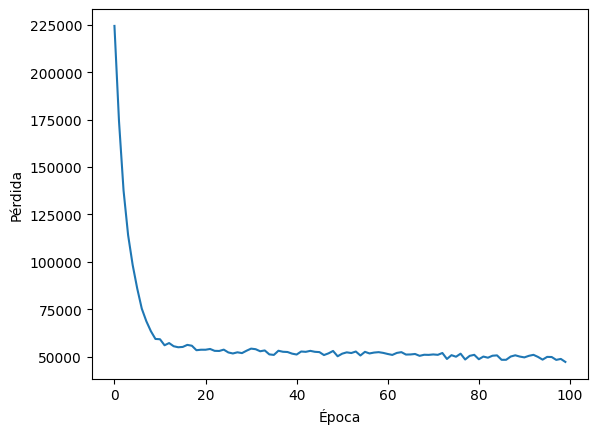

In [ ]:
milin.to(disp)
ecm = nn.MSELoss()
hist = entrena(milin, ecm, X_ent, y_ent, tasa=1e-2)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

## Clases y funciones para optimizadores
Hacemos una versión de la función `paso_ent` que utilice una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos en lugar de programarlo explícitamente. Esta versión ahora recibe la instancia de `Optimizer` (`optim`) y ya no requiere el valor de la tasa de aprendizaje (`tasa`).

In [ ]:
def paso_ent_opt(modelo, fp, opt, X, y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
  return perdida_paso

También es necesaria una versión de `entrena` que reciba una instancia de `Optimizer` (`optim`) y ya no requiera el valor de la tasa de aprendizaje (`tasa`). Esta función llamaría a `paso_ent_opt` en lugar de `paso_ent`.

In [ ]:
def entrena_opt(modelo, fp, opt, X, y, t_lote = 32, n_epocas = 100):
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora
  hist = [] # para guardar las pérdidas por época
  for e in range(n_epocas):
    perdida = 0
    perm = th.randperm(X.shape[0]) # se genera una permutación aleatoria
    Xperm = X[perm] # se reordenan las entradas y
    yperm = y[perm] # las entradas usando la permutación

    for lote in range(n_lotes): # se van tomando t_lote de las entradas
                                # y salidas reordenadas
      Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
      ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
      perdida += paso_ent_opt(modelo, fp, opt, Xlote, ylote) # se realiza 1 paso
                                                             # de entrenamiento
    hist.append(perdida)

  return hist

Instanciamos y entrenamos un modelo de regresión lineal con estas dos versiones de las funciones y graficamos la pérdida.

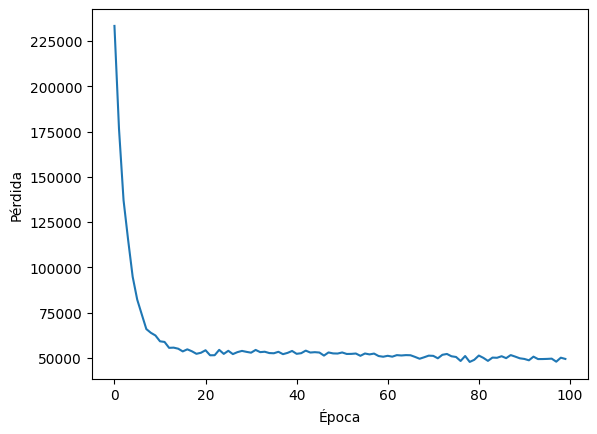

In [ ]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)
ecm = nn.MSELoss()
opt = SGD(milin.parameters(), lr = 1e-2)
hist = entrena_opt(milin, ecm, opt, X_ent, y_ent)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Usando la clase base `Optimizer` se pueden definir diferentes algoritmos de optimización para entrenar modelos con la misma interfaz general. Esto ofrece la flexibilidad de cambiar entre algoritmos simplemente instanciando la clase del optimizador de interés y pasándolo como argumento. Incluso es posible definir un algoritmo propio generando una subclase de `Optimizer` y especificando los métodos:
- `__init__`: El constructor de la clase, el cual recibe como argumento los parámetros a optimizar (`params`) como iterable. En este método se llama al constructor de la súperclase mediante la función `super`.
- `step`: Especifica la regla con la que se actualizan los parámetros pasados como argumento al constructor usando los gradientes obtenidos al llamar `.backward` (almacenados en el elemento `grad` de la instancia de `Parameter`). Este método no recibe argumentos.

In [ ]:
class MiSGD(th.optim.Optimizer):
  def __init__(self, params, lr=1e-3):
    super(MiSGD, self).__init__(params, defaults = {'lr':lr})

  def step(self):
    for g in self.param_groups:
      for p in g['params']:
        p.data.subtract_(self.defaults['lr'] * p.grad)

Instanciamos y entrenamos un modelo de regresión lineal con este optimizador y graficamos la pérdida.

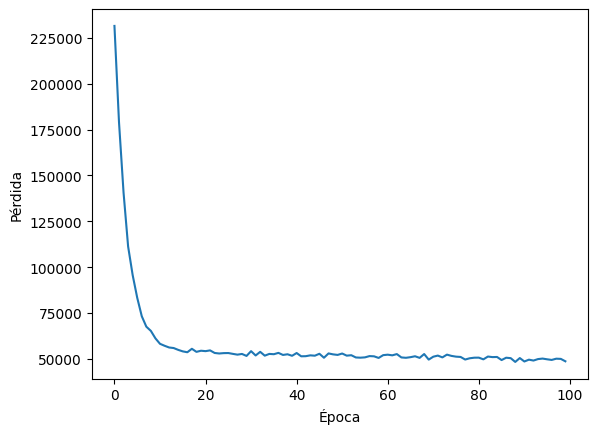

In [ ]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)
ecm = nn.MSELoss()
opt = MiSGD(milin.parameters(), lr = 1e-2)
hist = entrena_opt(milin, ecm, opt, X_ent, y_ent)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

## Contenedor `Sequential`
`Sequential` es un contenedor que permite generar una subclase de `Module` a través de una lista o tupla de capas predefinidas que se conectan de manera secuencial (la salida de una capa es la entrada de la siguiente). Por ej. para definir una red densa o completamente conectada con dos capas ocultas y una de salida:

In [ ]:
modelo = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.Sigmoid(),
                       nn.Linear(10,20),
                       nn.Sigmoid(),
                       nn.Linear(20, 1))

Movemos nuestra red a la GPU, creamos el criterio de ECM, instanciamos el optimizador, entrenamos y graficamos la pérdida.

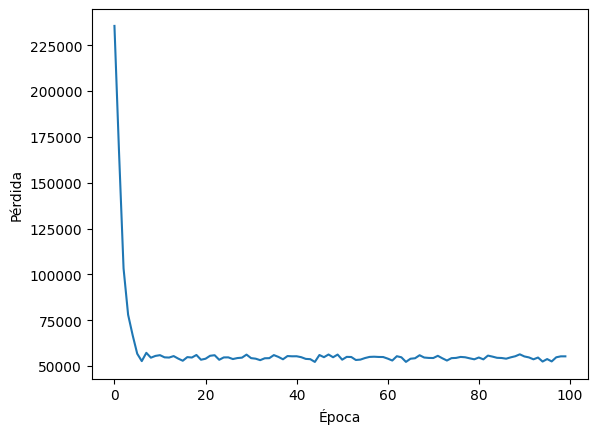

In [ ]:
modelo.to(disp)
ecm = nn.MSELoss()

optim = MiSGD(modelo.parameters(), lr = 1e-3)
hist = entrena_opt(modelo, ecm, optim, X_ent, y_ent)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Esta misma red podemos especificarla definiendo una subclase de `Module` como:

In [ ]:
class MiMLP(nn.Module):
  def __init__(self, d_ent):
    super(MiMLP, self).__init__()
    self.c1 = nn.Linear(d_ent, 10)
    self.c2 = nn.Linear(10, 20)
    self.salida = nn.Linear(20, 1)

  def forward(self, x):
    x = nn.functional.sigmoid(self.c1(x))
    x = nn.functional.sigmoid(self.c2(x))
    return self.salida(x)

Instanciamos esta subclase, la movemos a la GPU, creamos el criterio de ECM, instanciamos el optimizador, entrenamos la red y graficamos la pérdida.

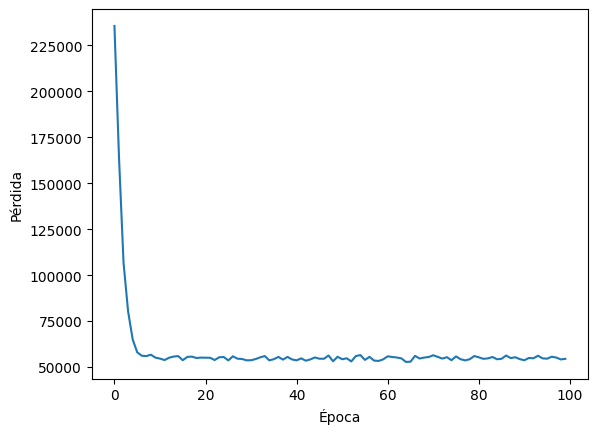

In [ ]:
modelo = MiMLP(X_ent.shape[-1])
modelo.to(disp)

ecm = nn.MSELoss()
opt = MiSGD(modelo.parameters(), lr = 1e-3)
hist = entrena_opt(modelo, ecm, opt, X_ent, y_ent)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Es posible trabajar con listas de instancias de `Module` en la definición de una subclase de `Module`. Sin embargo, es necesario hacerlo mediante la clase `ModuleList` para que puedan ser visibles para las demás instancias, funciones y herramientas de PyTorch. A diferencia de `Sequential`, no se presupone que las capas de una lista de `ModuleList` están conectadas secuencialmente. En cambio, esto se define dentro del método `__forward__`, como para cualquier otra capa. La red anterior se podría definir con `ModuleList` como:

In [ ]:
class MLPModList(nn.Module):
  def __init__(self, d_ent):
    super(MLPModList, self).__init__()
    self.cod = nn.ModuleList([nn.Linear(d_ent, 10), nn.Linear(10, 20)])
    self.salida = nn.Linear(20, 1)

  def forward(self, x):
    for c in self.cod:
      x = nn.functional.sigmoid(c(x))
    return self.salida(x)

Instanciamos esta subclase, la movemos a la GPU, creamos el criterio de ECM, instanciamos el optimizador, entrenamos la red y graficamos la pérdida.

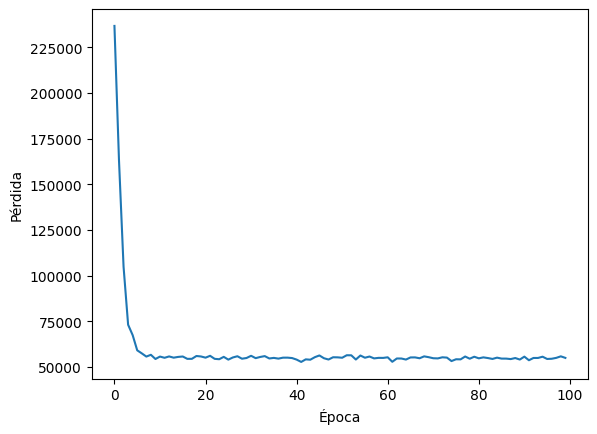

In [ ]:
modelo = MLPModList(X_ent.shape[-1])
modelo.to(disp)

ecm = nn.MSELoss()
opt = MiSGD(modelo.parameters(), lr = 1e-3)
hist = entrena_opt(modelo, ecm, opt, X_ent, y_ent)

plt.plot(hist)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

## Función `compile`
PyTorch 2 provee además la función `compile`, la cual recibe una instancia o una función como argumento y regresa una versión de la misma optimizada  mediante el compilador _just-in-time_ (JIT) [TorchDynamo](https://pytorch.org/docs/stable/dynamo/index.html). Para funciones, es posible usar `compile` como decorador. Como argumento opcional `compile` recibe uno de los siguientes modos (argumento `mode`):
- `default`: Intenta compilar sin tomar mucho tiempo ni usar memoria adicional.
- `reduce-overhead`: Busca reducir el cómputo innecesario asociado al marco de trabajo a costa de un pequeño incremento en requerimientos de memoria.
- `max-autotune`: Trata de generar el código más rápido sin importar el tiempo de compilación

In [ ]:
modelo = MLPModList(X_ent.shape[-1])
modelo.to(disp)

ecm = nn.MSELoss()
opt = MiSGD(modelo.parameters(), lr = 1e-3)

modelo_compiled = th.compile(modelo)

hist = entrena_opt(modelo_compiled, ecm, opt, X_ent, y_ent)